# Obtaining Dataset 

In [1]:
# import zipfile
# with zipfile.ZipFile("Dataset/BACH2018.zip","r") as zip_ref:
#     zip_ref.extractall()

# Importing Necessary Libraries

In [2]:
# First installation
# %pip install keras_applications

In [1]:
import time
start = time.time()

import shutil
import os
import cv2
import json
import itertools
import keras
import gc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from PIL import Image

from keras import backend as K
from keras import layers
from keras.applications import ResNet50, InceptionV3, InceptionResNetV2
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

%matplotlib inline

# Assigning Parameters
InceptionV3: 299 image size <br>
Resnet: 224 image size <br>
InceptionResnetV2: 299 image size <br>
EfficientNetV2S: 384 image size <br>
AlexNet: 227 image size

In [2]:
IMG_SIZE = 299
BATCH_SIZE = 16
EPOCHS = 40

# Loading Dataset Images
When loading the images, we perform some preprocessing first where we convert the images into the required dimensions to be fed into the CNN model for training.

In [3]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
  IMG = []
  read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
  for IMAGE_NAME in tqdm(os.listdir(DIR)):
      PATH = os.path.join(DIR,IMAGE_NAME)
      _, ftype = os.path.splitext(PATH)
      if ftype == ".tif":                        # Transfer tif images to array images 
          img = read(PATH)                       # read image path & convert to RGB
          img = cv2.resize(img, (RESIZE,RESIZE)) # resize image
          IMG.append(np.array(img))              # convert image to numpy array & append to array of images
  return IMG

# Loading the dataset for each class
benign_data = np.array(Dataset_loader('Photos/Benign',IMG_SIZE))
insitu_data = np.array(Dataset_loader('Photos/InSitu',IMG_SIZE))
invasive_data = np.array(Dataset_loader('Photos/Invasive',IMG_SIZE))
normal_data = np.array(Dataset_loader('Photos/Normal',IMG_SIZE))

100%|██████████| 101/101 [00:02<00:00, 49.07it/s]


# Creating Labels for the dataset
Our dataset consists of 400 images split into four classes: Benign, InSitu, Invasive, Normal. With the loaded dataset, we create numeric labels for each of the classes and combine all the images into a single shuffled dataset to be used later.

In [4]:
# Create labels
benign_label = np.zeros(len(benign_data))
insitu_label = np.ones(len(insitu_data))
invasive_label = np.full(len(invasive_data), 2)
normal_label = np.full(len(normal_data), 3)

# Merge data
X = np.concatenate((benign_data, insitu_data, invasive_data, normal_data), axis = 0)
Y = np.concatenate((benign_label, insitu_label, invasive_label, normal_label), axis = 0)

# Shuffle data
s = np.arange(X.shape[0])
np.random.seed(1234)
np.random.shuffle(s)
X = X[s]
Y = Y[s]

# Change Y to categorical
Y = to_categorical(Y, num_classes= 4)

# Split into Training, Validation and Testing datasets
The shuffled dataset is split into three sections for training, validation and testing data. We use a 70:15:15 ratio to split our dataset. We also write out or testing dataset images into a local directory so that these unseen images can be inputted to our web application UI.

In [5]:
# Training set
x_train, X_remainder, y_train, Y_remainder = train_test_split(
    X, Y, 
    train_size=0.7, 
    random_state=1234
    )
# Validation and Test set
x_val, x_test, y_val, y_test = train_test_split(
    X_remainder, Y_remainder, 
    train_size=0.5, 
    random_state=1234
    )


In [6]:
# Saving test images to be used through UI
shutil.rmtree("test")
os.mkdir("test")
labels = ["benign", "insitu", "invasive", "normal"]
for i in range(len(x_test)):
    data = Image.fromarray(x_test[i])
    label = labels[np.argmax(y_test[i])]
    filepath = f"test/{i+1}_{label}.png"
    data.save(filepath)

# Displaying some images with their Labels
Here we will be displaying some of the images from our dataset with their corresponding labels.

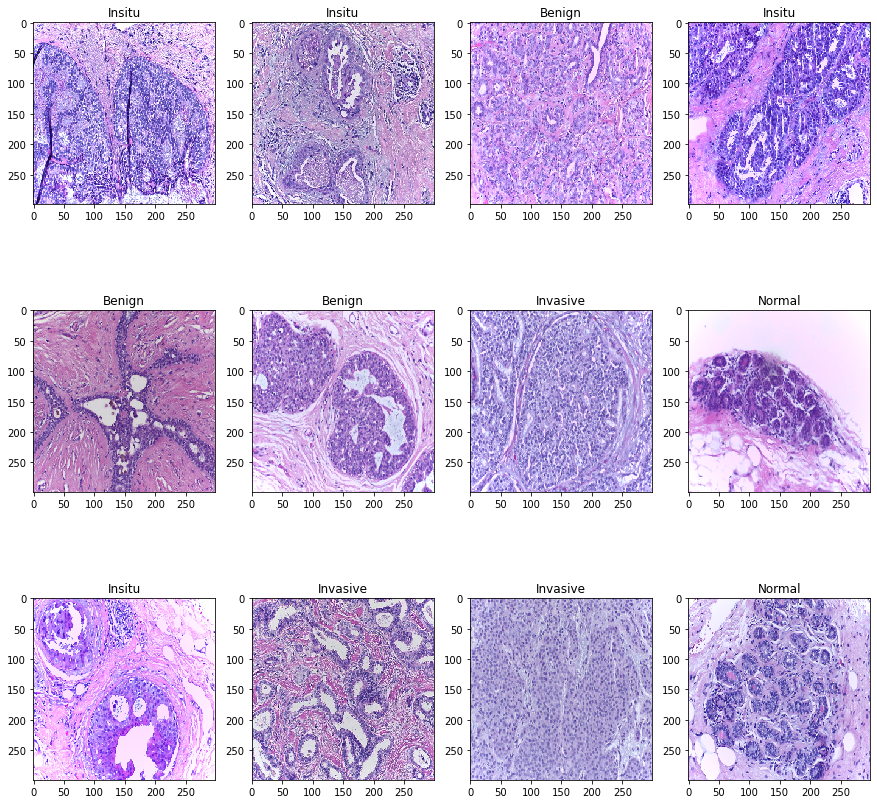

In [7]:
# Display the first 15 images and their labels
w = 60; h = 40
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(y_train[i]) == 0:
        ax.title.set_text('Benign')
    elif np.argmax(y_train[i]) == 1:
        ax.title.set_text('Insitu')
    elif np.argmax(y_train[i]) == 2:
        ax.title.set_text('Invasive')
    else:
        ax.title.set_text('Normal')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# CNN Model

## Building model

In [9]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D(name = "final"))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(4, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [8]:
# Using original generator for data augmentation
train_generator = ImageDataGenerator(
        zoom_range = 2,  # set range for random zoom
        rotation_range = 90, # set range for image rotation
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images 
    )

In [10]:
K.clear_session()
gc.collect()

myModel =  InceptionResNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE,IMG_SIZE,3)
)

model = build_model(myModel, lr = 1e-4)

model.summary()

2022-09-27 01:29:39.600790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-27 01:29:40.079256: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15133 MB memory:  -> device: 0, name: Quadro P5000, pci bus id: 0000:91:00.0, compute capability: 6.1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 final (GlobalAveragePooling  (None, 1536)             0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 batch_normalization_203 (Ba  (None, 1536)             6144      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 4)                 6148      
                                                        

/home/student/miniconda3/envs/mds5/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Training and Evaluation of model

In [11]:
# Model callbacks
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.InceptionResNetV2.hdf5" # can save to a specific folder
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Early stopping
early_checkpoint = EarlyStopping(patience = 10, monitor = 'val_accuracy', mode = "max")           

In [12]:
# history = model.fit_generator(
#     train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
#     steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
#     epochs=EPOCHS,
#     validation_data=(x_val, y_val),
#     callbacks=[learn_control, checkpoint]
# )

history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE), 
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,      
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint, early_checkpoint],
    verbose=0
    ) 

/tmp/ipykernel_370248/3952370598.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40


2022-09-27 01:29:58.943360: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-09-27 01:29:59.177820: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


18/17 [==============================] - ETA: 0s - loss: 1.8941 - accuracy: 0.3143
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to weights.InceptionResNetV2.hdf5
17/17 [==============================] - 34s 1s/step - loss: 1.8941 - accuracy: 0.3143 - val_loss: 1.7238 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 2/40
18/17 [==============================] - ETA: 0s - loss: 1.6496 - accuracy: 0.4179
Epoch 2: val_accuracy improved from 0.25000 to 0.35000, saving model to weights.InceptionResNetV2.hdf5
17/17 [==============================] - 13s 718ms/step - loss: 1.6496 - accuracy: 0.4179 - val_loss: 1.5584 - val_accuracy: 0.3500 - lr: 1.0000e-04
Epoch 3/40
18/17 [==============================] - ETA: 0s - loss: 1.4126 - accuracy: 0.5071
Epoch 3: val_accuracy improved from 0.35000 to 0.46667, saving model to weights.InceptionResNetV2.hdf5
17/17 [==============================] - 12s 706ms/step - loss: 1.4126 - accuracy: 0.5071 - val_loss: 1.1026 - val_accuracy: 0.4

<AxesSubplot:>

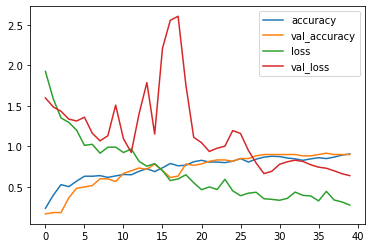

In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy','loss', 'val_loss']].plot()   

## K-Fold Cross Validation

In [ ]:
# K-FOLD
k = 5
kf = KFold(n_splits=k, random_state=None)
 
acc_score = []
prec_score = []
recall_score = []
f1_score = []

for train_index , test_index in kf.split(x_train):
    x_train_kf , x_test_kf = x_train[train_index],x_train[test_index]
    y_train_kf , y_test_kf = y_train[train_index] , y_train[test_index]
    y_test_kf = np.argmax(y_test_kf, axis=1) 
     
    model.fit(x_train_kf,y_train_kf)
    pred_values = model.predict(x_test_kf)
    pred_values=np.argmax(pred_values, axis=1)
    acc = accuracy_score(pred_values , y_test_kf)
    prec = precision_score(pred_values , y_test_kf, average='micro')
    report = classification_report(y_test_kf, pred_values) 
    print(report)
    
    acc_score.append(acc)
    prec_score.append(prec)

     
avg_acc_score = sum(acc_score)/k
 # okok
# print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))


2/2 [==============================] - 3s 227ms/step
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       1.00      0.94      0.97        17
           2       1.00      1.00      1.00         9
           3       0.88      1.00      0.94        15

    accuracy                           0.96        56
   macro avg       0.97      0.97      0.97        56
weighted avg       0.97      0.96      0.96        56

2/2 [==============================] - 0s 224ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.94      1.00      0.97        17
           2       1.00      1.00      1.00        14
           3       1.00      0.93      0.97        15

    accuracy                           0.98        56
   macro avg       0.99      0.98      0.98        56
weighted avg       0.98      0.98      0.98        56

2/2 [===================

# Prediction

In [ ]:
model.load_weights("weights.InceptionResNetV2.hdf5") # load the best checkpoint weights
y_pred = model.predict(x_test)          # predict on test set
accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)) # get accuracy score

2022-08-31 17:02:40.050593: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-31 17:02:40.287712: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


2/2 [==============================] - 6s 1s/step


0.9166666666666666

In [ ]:
# Test Time Augmentation Testing
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(x_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(x_test)/BATCH_SIZE)
    predictions.append(preds)
    gc.collect()
    
y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_309355/886357982.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(train_generator.flow(x_test, batch_size=BATCH_SIZE, shuffle=False),
  0%|          | 0/10 [00:03<?, ?it/s]


KeyboardInterrupt: 

## Confusion Matrix

Confusion matrix, without normalization
[[12  2  0  0]
 [ 1 16  0  0]
 [ 0  0 14  0]
 [ 0  2  0 13]]


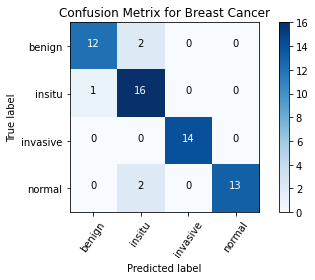

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    ok
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

cm_plot_label =['benign', 'insitu', 'invasive', 'normal'] 
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

## Classification Report

In [ ]:
report = classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
print(report)

              precision    recall  f1-score   support

           0       0.92      0.86      0.89        14
           1       0.80      0.94      0.86        17
           2       1.00      1.00      1.00        14
           3       1.00      0.87      0.93        15

    accuracy                           0.92        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.92      0.92        60



# Runtime Report

In [ ]:
runtime = 'Running time: %.4f seconds' % (time.time()-start)
print(runtime)

Running time: 512.7841 seconds


# Saving the model

In [ ]:
path="saved_model/InceptionResNetV2"
tf.keras.models.save_model(model, path)

INFO:tensorflow:Assets written to: saved_model/InceptionResNetV2/assets


INFO:tensorflow:Assets written to: saved_model/InceptionResNetV2/assets
